In [1]:
import os, glob, re, random, gzip, json, pysam
from collections import Counter, defaultdict, OrderedDict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns

In [7]:
def get_rgb(s):
    return tuple([int(v)/255 for v in s.split(",")])

def plot_chrom_barplot_axes(ax, d, xlim=None, ylim=None, title=None, xlabel=None, ylabel=None, ytick=True):
    ys = np.arange(len(d)) + 0.5
    xs1 = d["Crick"]
    xs2 = d["Crick.HP1"]
    xs3 = d["Crick.HP2"]
    xs4 = d["Watson"]
    xs5 = d["Watson.HP1"]
    xs6 = d["Watson.HP2"]
    
    crick = sum(d["Crick"])
    watson = sum(d["Watson"])
    
    mean1 = np.mean(xs1)
    mean2 = np.mean(xs4)
    if xlim is None:
        xlim = max(max(max(xs1), max(xs4)) * 1.2, 10)

    ax0 = plt.gca()
    plt.sca(ax)
    plt.barh(ys, xs1, height=1, color=colors[0])
    plt.barh(ys, xs2, height=1, color=colors[2])
    plt.barh(ys, xs3, left=xs2, height=1, color=colors[3])
    plt.barh(ys, -xs4, height=1, color=colors[1])
    plt.barh(ys, -xs5, left=-xs6, height=1, color=colors[2])
    plt.barh(ys, -xs6, height=1, color=colors[3])
    plt.plot([0, 0], [0, len(xs1)], lw=1, color="black")
    for x, y in zip(xs1, ys):
        if x >= xlim:
            plt.scatter(xlim, y, s=1, marker="o", color="black", clip_on=False, zorder=12)
    for x, y in zip(xs4, ys):
        if x >= xlim:
            plt.scatter(-xlim, y, s=1, marker="o", color="black", clip_on=False, zorder=12)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if not ytick:
        plt.yticks([])
    plt.xticks([])
    plt.xlim(-xlim, xlim)
    plt.ylim(0, ylim)
    if True:
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.sca(ax0)
    
colors = ["135,169,235", "248,173,97", "43,100,216", "215,55,42"]
colors = list(map(get_rgb, colors))
colors[2] = "blue"
colors[3] = "red"

## 20220430_S5Merged.sc157

In [17]:
cell = "20220430_S5Merged.sc157"
bam = "../../1_NanoStrandSeq/results/mapping/mark_duplicate/%s/%s.bam" % (cell.split(".")[0], cell)
tsv = "results/counts/%s.bin_reads.tsv" % cell
if not os.path.exists(tsv):
    ! sstools StatBinRead -t 20 -c -w 2000000 {bam} {tsv}

sstools StatBinRead -t 20 -c -w 2000000 ../../1_NanoStrandSeq/results/mapping/mark_duplicate/20220430_S5Merged/20220430_S5Merged.sc157.bam results/counts/20220430_S5Merged.sc157.bin_reads.tsv


In [18]:
chroms = ["chr%d" % i for i in range(1, 23)] + ["chrX"]
dat = pd.read_csv(tsv, sep="\t")
print(np.mean(dat["Crick"] + dat["Watson"]))
d = dat
max_bin_count = sum(dat["Chrom"] == "chr1")
vs = list(d["Crick"]) + list(d["Watson"])
if True:
    vs = list(filter(lambda item: item > 0, vs))
    if len(vs) > 10:
        vs = vs[int(len(vs) * 0.1):int(len(vs) * 0.9)]
    if len(vs) > 0:
        mean = np.mean(vs)
        std = np.std(vs)
    else:
        mean = 0
        std = 0
    xlim = max(mean + 2 * std, 10)
    xlim = mean * 3
else:
    xlim = max(vs) * 1.2

193.75368826170623


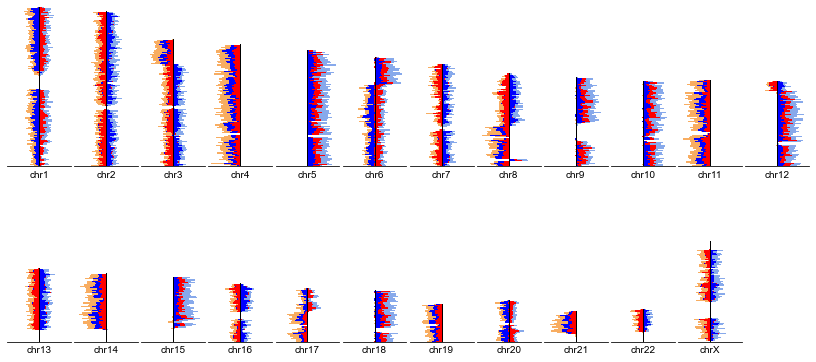

In [8]:
nrow, ncol = 2, 12
fig, axs = plt.subplots(nrow, ncol, figsize=(11.6, 5), sharex=True, sharey=True,
                        gridspec_kw={"wspace": 0.05, "hspace": 0.1,
                                     "left": 0.02, "right": 0.98,
                                     "bottom": 0.05, "top": 0.98})
for ci, chrom in enumerate(chroms):
    ax = axs[int(ci / ncol)][ci % ncol]
    d2 = d[d["Chrom"] == chrom]
    plot_chrom_barplot_axes(ax, d2, xlim=xlim, ylim=max_bin_count, xlabel=chrom, ytick=False)
for ai in range(nrow * ncol):
    if ai >= len(chroms):
        axs[int(ai/ncol)][ai%ncol].set_visible(False)
plt.savefig("figures/crick_watson_barplot.%s.pdf" % cell, dpi=300)

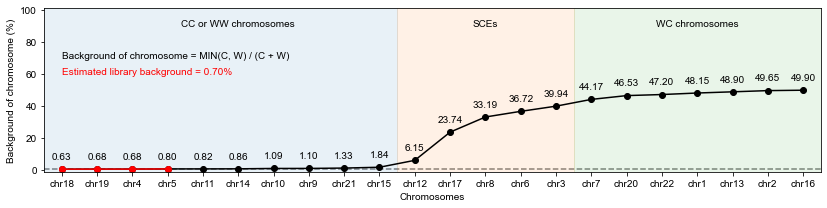

In [9]:
# background of chromosome

rows = []
d = dat
for i in range(1, 23):
    chrom = "chr%d" % i
    tmp = d[d["Chrom"] == chrom]
    c = tmp["Crick"].sum()
    w = tmp["Watson"].sum()
    bg = min(c, w) / (c + w)
    rows.append([bg, chrom])
rows.sort()

xs = np.arange(len(rows))
ys = [row[0] * 100 for row in rows]
ticks = [row[1] for row in rows]

plt.figure(figsize=(11.6, 3))
plt.plot(xs, ys, marker="o", color="black")
plt.plot(xs[:4], ys[:4], marker="o", color="red")
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(-1, 101)
plt.axvspan(-0.5, 9.5, alpha=0.1, color="C0")
plt.axvspan(9.5, 14.5, alpha=0.1, color="C1")
plt.axvspan(14.5, 21.5, alpha=0.1, color="C2")

for x, y in zip(xs, ys):
    plt.text(x, y + 5, "%.2f" % y, va="bottom", ha="center", rotation=0)
    
plt.text(5, 90, "CC or WW chromosomes", ha="center")
plt.text(12, 90, "SCEs", ha="center")
plt.text(18, 90, "WC chromosomes", ha="center")

bg = np.mean(ys[:4])
plt.text(0, 70, "Background of chromosome = MIN(C, W) / (C + W)")
plt.text(0, 60, "Estimated library background = %.2f%%" % bg, color="red")
plt.axhline(bg, color="grey", ls="--", zorder=-1)

plt.xticks(xs, ticks, rotation=0)
plt.xlabel("Chromosomes")
plt.ylabel("Background of chromosome (%)")
plt.tight_layout()
plt.savefig("figures/background_schema.%s.pdf" % cell,dpi=300)

## 20221005_MEF.C17

In [22]:
cell = "20221005_MEF.C17"
bam = "../../1_NanoStrandSeq/results/mapping/mark_duplicate/%s/%s.bam" % (cell.split(".")[0], cell)

tsv1 = "results/counts/%s.bin_reads.tmp1.tsv" % cell
tsv2 = "results/counts/%s.bin_reads.tmp2.tsv" % cell
tsv = "results/counts/%s.bin_reads.tsv" % cell

if not os.path.exists(tsv):
    ! sstools StatBinRead -t 20 -c -w 2000000 {bam} {tsv} 2> /dev/null
#     ! sstools StatBinRead -t 20 -c -w 2000000 {bam} {tsv1} 2> /dev/null
#     ! sstools StatBinRead -t 20 -w 2000000 {bam} {tsv2} 2> /dev/null
#     dat1 = pd.read_csv(tsv1, sep="\t")
#     dat2 = pd.read_csv(tsv2, sep="\t")
#     d1 = dat1[(dat1["Chrom"] != "chrX") & (dat1["Chrom"] != "chrY")]
#     d2 = dat2[(dat2["Chrom"] == "chrX") | (dat2["Chrom"] == "chrY")]
#     dat = pd.concat([d1, d2])
#     dat.to_csv(tsv, sep="\t", index=False)
#     ! rm {tsv1} {tsv2}

In [23]:
chroms = ["chr%d" % i for i in range(1, 20)] + ["chrX"]

dat = pd.read_csv(tsv, sep="\t")
print(np.mean(dat["Crick"] + dat["Watson"]))

d = dat
max_bin_count = sum(dat["Chrom"] == "chr1")

vs = list(d["Crick"]) + list(d["Watson"])
if True:
    vs = list(filter(lambda item: item > 0, vs))
    if len(vs) > 10:
        vs = vs[int(len(vs) * 0.1):int(len(vs) * 0.9)]
    if len(vs) > 0:
        mean = np.mean(vs)
        std = np.std(vs)
    else:
        mean = 0
        std = 0
    xlim = max(mean + 2 * std, 10)
    xlim = mean * 3
else:
    xlim = max(vs) * 1.2

126.74418604651163


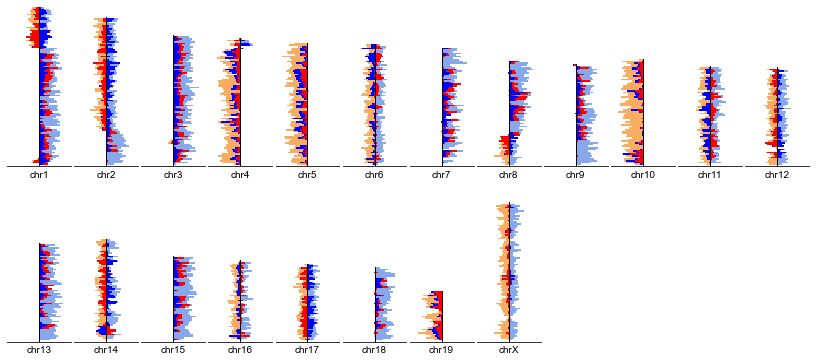

In [24]:
nrow, ncol = 2, 12
fig, axs = plt.subplots(nrow, ncol, figsize=(11.6, 5), sharex=True, sharey=True,
                        gridspec_kw={"wspace": 0.05, "hspace": 0.1,
                                     "left": 0.02, "right": 0.98,
                                     "bottom": 0.05, "top": 0.98})
for ci, chrom in enumerate(chroms):
    ax = axs[int(ci / ncol)][ci % ncol]
    d2 = d[d["Chrom"] == chrom]
    plot_chrom_barplot_axes(ax, d2, xlim=xlim, ylim=max_bin_count, xlabel=chrom, ytick=False)
for ai in range(nrow * ncol):
    if ai >= len(chroms):
        axs[int(ai/ncol)][ai%ncol].set_visible(False)
plt.savefig("figures/crick_watson_barplot.%s.pdf" % cell, dpi=300)